# Effect of Class Length on Grades
Alexander Bailey, Kayli Leung

## Question

Is there a significant difference in the percentage of A's given based on the length a class. 

## Hypotheses
Null Hypothesis: There is no significant difference in the mean percentage of A's in classes of different lengths.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in classes of different lengths.

## Methodology
We select an alpha value of 0.025.

We will perform ANOVA testing on three time sets, and then a two-tail, two-sample t-test on each unique pairing of class lengths. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Imports

In [19]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
%config InlineBackend.figure_format ='retina'

np.random.seed(15)

## Connect and Retrieve Data

In [4]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [5]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sched.end_time
, sect.section_type
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [6]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count
0,16,2,5,0,0,0,0,800,850,LAB,23
1,0,0,0,0,0,0,0,-1,-1,FLD,0
2,0,0,0,0,0,0,0,-1,-1,FLD,0
3,0,0,0,0,0,0,0,-1,-1,FLD,0
4,0,0,0,0,0,0,0,-1,-1,FLD,0


## Data Cleaning

Create column for class length:

In [7]:
df['class_length'] = df['end_time'] - df['start_time']
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
0,16,2,5,0,0,0,0,800,850,LAB,23,50
1,0,0,0,0,0,0,0,-1,-1,FLD,0,0
2,0,0,0,0,0,0,0,-1,-1,FLD,0,0
3,0,0,0,0,0,0,0,-1,-1,FLD,0,0
4,0,0,0,0,0,0,0,-1,-1,FLD,0,0


In [8]:
df.loc[df['class_length'] == 0,'section_type'].value_counts()

IND    81726
LEC     4405
FLD     3691
SEM     1345
LAB     1331
DIS       19
Name: section_type, dtype: int64

It appears that all classes with a start and end time of -1 also have a class length of 0, mostly independent studies and other classes lacking a regular schedule. Since these are not useful in our current test, we can drop classes with a length of 0. We can also drop all section types that are tied to other classes, like labs and discussions.

In [9]:
df = df[df['class_length'] > 0]
df = df[df['section_type'] != 'IND']
df = df[df['section_type'] != 'FLD']
df = df[df['section_type'] != 'LAB']
df = df[df['section_type'] != 'DIS']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97444 entries, 13 to 217389
Data columns (total 12 columns):
a_count         97444 non-null int64
ab_count        97444 non-null int64
b_count         97444 non-null int64
bc_count        97444 non-null int64
c_count         97444 non-null int64
d_count         97444 non-null int64
f_count         97444 non-null int64
start_time      97444 non-null int64
end_time        97444 non-null int64
section_type    97444 non-null object
total_count     97444 non-null int64
class_length    97444 non-null int64
dtypes: int64(11), object(1)
memory usage: 9.7+ MB


In [10]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
13,0,0,0,0,0,0,0,725,775,LEC,0,50
88728,0,0,0,0,0,0,0,960,1035,LEC,0,75
88725,0,0,0,0,0,0,0,840,960,SEM,0,120
88685,0,0,0,0,0,0,0,790,910,LEC,0,120
88645,0,0,0,0,0,0,0,1050,1200,LEC,0,150


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [11]:
df = df[df['total_count'] != 0]

In [12]:
df['total_count'].value_counts().head()

19    3068
13    3032
10    2755
11    2727
15    2727
Name: total_count, dtype: int64

In [13]:
df.sort_values(by='class_length',ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
168714,11,0,0,0,0,0,0,30,840,LEC,11,810
168715,11,0,0,0,0,0,0,30,840,LEC,11,810
148583,6,6,1,0,0,0,0,150,920,LEC,13,770
18287,66,62,20,6,0,0,0,360,1020,LEC,154,660
193594,12,0,0,0,0,0,0,360,1020,LEC,12,660


In [14]:
df['class_length'].value_counts().head()

50     31848
75     29056
120     5935
150     4812
180     3157
Name: class_length, dtype: int64

In [15]:
df2 = df.copy()

Calculate the Ratio of As for each class

In [16]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

There are some duplicate rows, so we can drop those.

In [17]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61440 entries, 43 to 217388
Data columns (total 13 columns):
a_count         61440 non-null int64
ab_count        61440 non-null int64
b_count         61440 non-null int64
bc_count        61440 non-null int64
c_count         61440 non-null int64
d_count         61440 non-null int64
f_count         61440 non-null int64
start_time      61440 non-null int64
end_time        61440 non-null int64
section_type    61440 non-null object
total_count     61440 non-null int64
class_length    61440 non-null int64
ratio_of_as     61440 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 6.6+ MB


Here we are dividing classes into 3 categories:<br />
short: 1 hour or less<br />
medium: 1-2 hrs<br />
long: 2-3 hrs<br /> 

In [18]:
df_short = df2[df2['class_length'].between(1,60)]
df_med = df2[df2['class_length'].between(61,120)]
df_long = df2[df2['class_length'].between(121,180)]
lengths = {'Short' : df_short,'Medium' : df_med, 'Long' : df_long}

for key,value in lengths.items():
    print("Number of " + key + " Classes: " + str(len(value)))


Number of Short Classes: 23985
Number of Medium Classes: 29999
Number of Long Classes: 6646


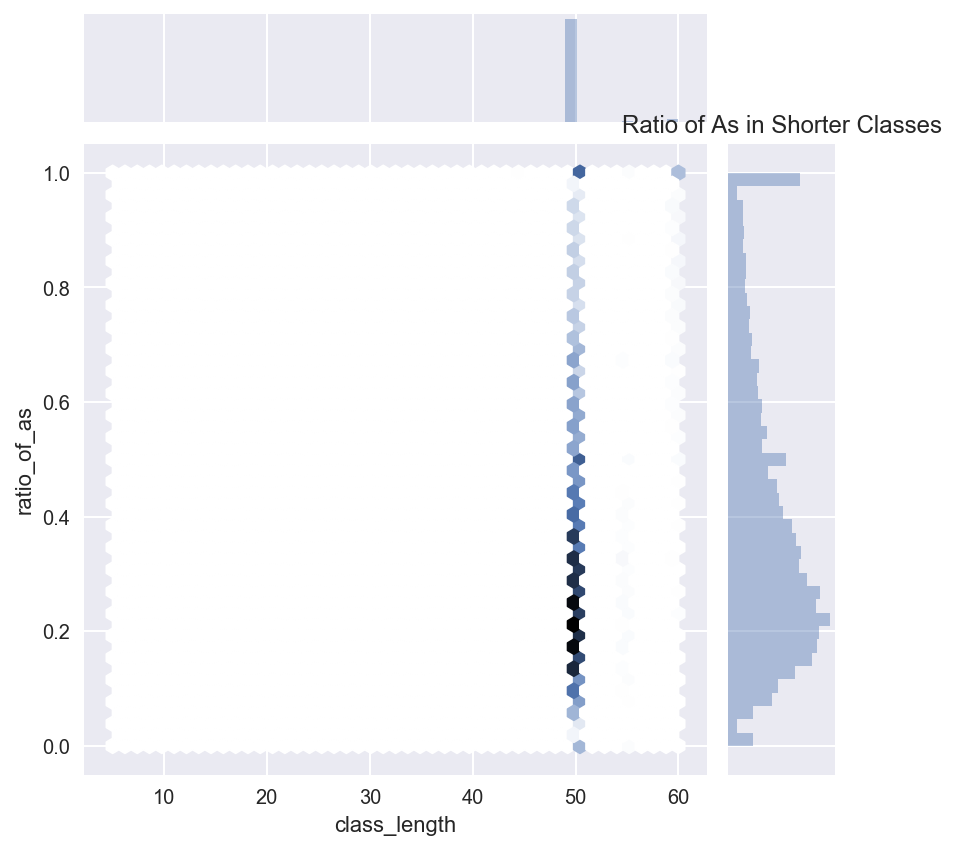

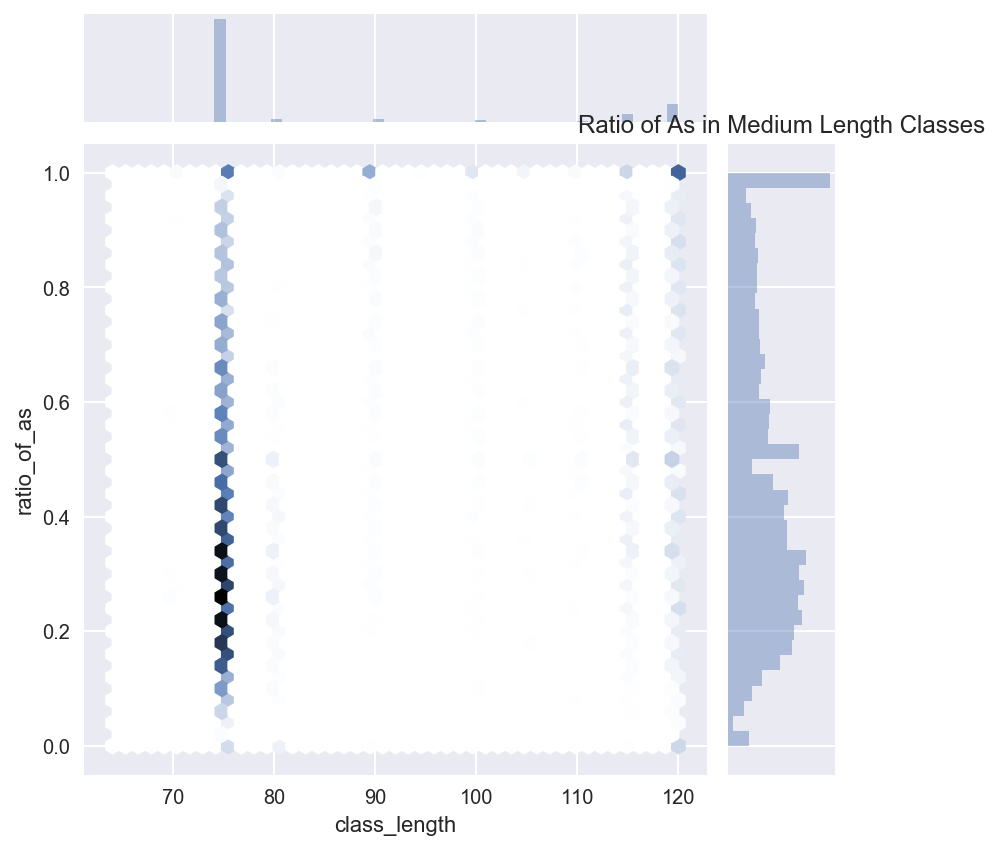

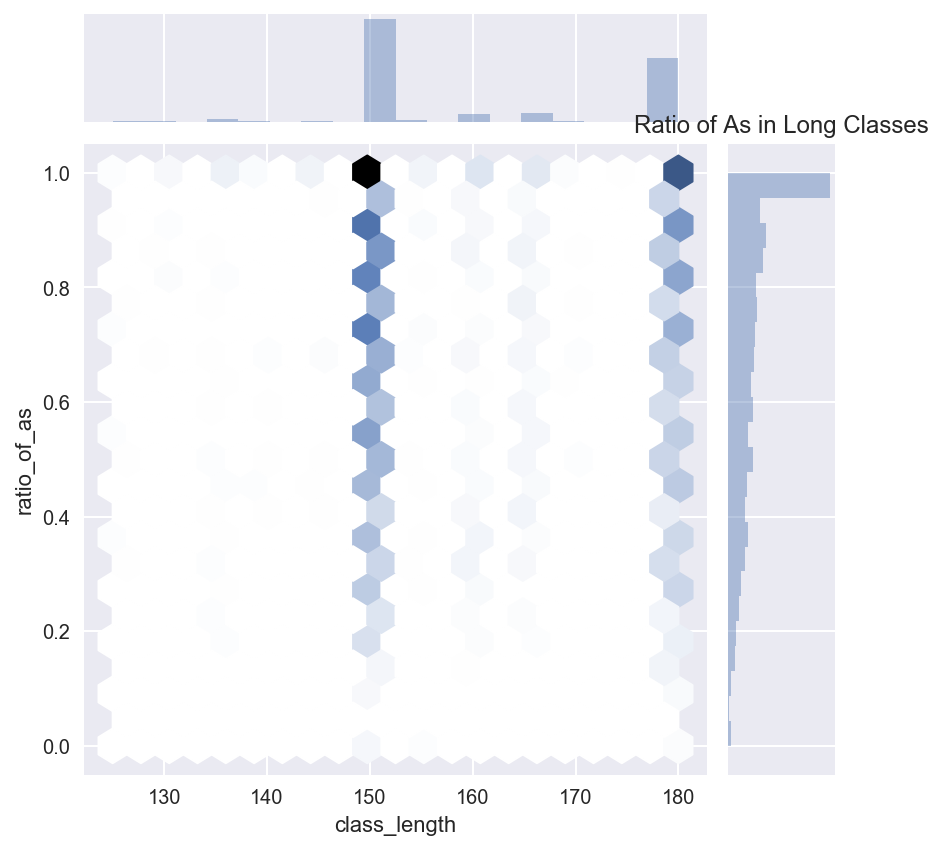

In [20]:
sns.jointplot('class_length', 'ratio_of_as',df_short, kind='hex')
plt.title('Ratio of As in Shorter Classes')
plt.show();
sns.jointplot('class_length', 'ratio_of_as',df_med, kind='hex')
plt.title('Ratio of As in Medium Length Classes')
plt.show();
sns.jointplot('class_length', 'ratio_of_as',df_long, kind='hex')
plt.title('Ratio of As in Long Classes')
plt.show();

# Modeling/Testing

## ANOVA Testing

Because we have several categories of length, we will use anova testing

In [20]:
df2['short'] = df2['class_length'].between(1,60).apply(lambda x : int(x))
df2['med'] = df2['class_length'].between(61,120).apply(lambda x : int(x))
df2['long'] = df2['class_length'].between(121,180).apply(lambda x : int(x))
df2.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length,ratio_of_as,short,med,long
49,2,1,1,2,2,2,1,660,710,LEC,11,50,0.181818,1,0,0
50,19,33,21,6,1,0,1,800,850,LEC,81,50,0.234568,1,0,0
51,2,9,2,0,0,0,0,800,850,LEC,13,50,0.153846,1,0,0
52,2,6,4,1,0,0,0,660,735,LEC,13,75,0.153846,0,1,0
53,2,5,3,0,0,0,0,1080,1130,LEC,10,50,0.200000,1,0,0


In [21]:
formula = "ratio_of_as ~ C(short) + C(med) + C(long)"
lm = ols(formula,df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq       df            F         PR(>F)
C(short)    71.644977      1.0  1057.299348  5.711013e-230
C(med)      40.421925      1.0   596.525765  4.040174e-131
C(long)      0.046045      1.0     0.679506   4.097601e-01
Residual  4163.041272  61436.0          NaN            NaN


Using the Bonferoni correction we adjust our alpha (0.05/3 = 0.0167), and we see that this ANOVA test demonstrates that class length may be influential. This test does not tell us how it impacts the percentage of A's yet, so we will now perform t-tests on the unique pairings.

## T-Tests

### Determining Sample Size

Running t-tests on all pairs for further analysis:

In [32]:
moe = 0.1
z = 1.96 # z value for alpha 0.05

var_n = {}

for key,value in lengths.items():
    var_n[key] = {'n':len(value['ratio_of_as']),
                  'var':np.var(value['ratio_of_as'])}


In [38]:
num = sum([(nvar['n'] - 1) * nvar['var'] for key,nvar in var_n.items()])
den = sum([nvar['n'] for key,nvar in var_n.items()]) - 3
pooled_std = np.sqrt(num/den)

n = 2 * (z * pooled_std / moe)**2
n_ceil = math.ceil(n)

We will use samples from short, med, and long of size 53.

### Running the Tests

In [42]:
np.random.seed(15)

short = df_short['ratio_of_as']
med = df_med['ratio_of_as']
long = df_long['ratio_of_as']

short_sample = np.random.choice(short, size=n_ceil)
med_sample = np.random.choice(med, size=n_ceil)
long_sample = np.random.choice(long, size=n_ceil)

In [43]:
print("Short vs Medium classes: " + str(stats.ttest_ind(short_sample, med_sample)))
print("Short vs Long classes: " + str(stats.ttest_ind(short_sample, long_sample)))
print("Medium vs Long classes: " + str(stats.ttest_ind(med_sample, long_sample)))

Short vs Medium classes: Ttest_indResult(statistic=-1.8649217538592497, pvalue=0.06501166236291837)
Short vs Long classes: Ttest_indResult(statistic=-6.973530213736794, pvalue=2.943206883718244e-10)
Medium vs Long classes: Ttest_indResult(statistic=-4.748706503277604, pvalue=6.573385293102591e-06)


When we compare these P-values to our alpha of 0.025 (0.05/2 for a two-tailed test) we can see there is a significant difference in the percentage of A's in classes longer than 2 hours when compared to other class lengths. This may also be influenced by longer classes meeting less days per week, so further research may be required. 